<a href="https://colab.research.google.com/github/johnberg1/COMP447-547-S22/blob/main/homework3/HW3_GANs_Diffusion_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Blackboard, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In this homework, you will be implementing GANs and diffusion models. 

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

You will be implementing the code using PyTorch. Some parts of the code such as function headers are already provided to you, you will need to fill out the parts with "YOUR CODE HERE". Feel free to create more cells and more functions or modify the existing ones if you wish.

After you complete the assignment, download the specified images outputted in the results/ folder (which you can find on the left dashboard by clicking the folder icon) and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [143]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/johnberg1/deepul.git
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 238, done.
remote: Total 238 (delta 0), reused 0 (delta 0), pack-reused 238
Receiving objects: 100% (238/238), 60.56 MiB | 5.67 MiB/s, done.
Resolving deltas: 100% (111/111), done.
Processing ./deepul
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=22835 sha256=d4f07073ee2c8d43cc96bb632705eb168210605ed570a3cbebd6dc7a983194cf
  Stored in directory: /tmp/pip-ephem-wheel-cache-5tgz4cc7/wheels/c1/d5/0d/e42f29f08bd81a15f097edc4c2927b15f7bcacfd56d2c66a84
Successfully built deepul
  Attempting uninstall: deepul
    Found existi

In [144]:
from deepul.hw3_helper import *
import deepul.pytorch_util as ptu
import warnings
warnings.filterwarnings('ignore')

# Question 1: DCGAN on Emoji Dataset [25 pts]

In the first two questions of this homework, you will be working on emoji datasets. In Q1, you will implement DCGAN on Windows emoji dataset. In Q2, you will implement a CycleGAN between the Windows and Apple emojis.

In [433]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

from six.moves.urllib.request import urlretrieve
import tarfile

import imageio

In [434]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Visualizing the Datasets

The following code will download the datasets and display example emojis from Apple and Windows.

data/emojis.tar.gz


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


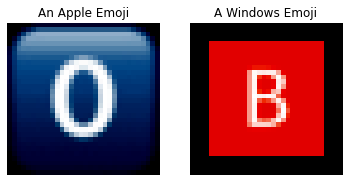

In [435]:
data_fpath = get_file(fname='emojis', 
                         origin='http://www.cs.toronto.edu/~jba/emojis.tar.gz', 
                         untar=True)
_, apple_test_loader = get_emoji_dataloader('Apple')
_, windows_test_loader = get_emoji_dataloader('Windows')
apple_sample = next(iter(apple_test_loader))[0][0].numpy().transpose(1,2,0)
windows_sample = next(iter(windows_test_loader))[0][0].numpy().transpose(1,2,0)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(apple_sample)
ax1.set_title('An Apple Emoji')
ax1.axis('off')

ax2.imshow(windows_sample)
ax2.set_title('A Windows Emoji')
ax2.axis('off')
fig.show()

### Solution
In this part, you need to implement a DCGAN architecture. Let's start with the Generator. The generator starts with a latent vector of size 100 and converts it to a 32x32x3 image. Here is a figure, describing the DCGAN generator:

![](https://drive.google.com/uc?export=view&id=1n3H29xfUHBnNO_rBwAzs2WXAPsIL1A64)


Also, here is a pseudocode for you to follow:

```
DCGenerator
    Linear(100, 128*4*4)
    reshape to B,C,H,W
    BatchNorm2d(128)
    ReLU

    nn.Upsample(2)
    Conv2d(128, 64, 5, stride=1, padding=2, bias=False)
    BatchNorm2d(64)
    ReLU

    nn.Upsample(2)
    Conv2d(64, 32, 5, stride=1, padding=2, bias=False)
    BatchNorm2d(32)
    ReLU

    nn.Upsample(2)
    Conv2d(32, 3, 5, stride=1, padding=2, bias=False)
    tanh

```



In [451]:
class DCGenerator(nn.Module):
    def __init__(self, noise_size=100):
        super(DCGenerator, self).__init__()
        """ YOUR CODE HERE """
        self.linear_layer = nn.Sequential(nn.Linear(noise_size, 128 * 4 * 4))
        #reshape
        self.conv_layers = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, 5, stride=1, padding=2, bias=False),
            nn.Tanh(),
        )
    def forward(self, z):
        """ YOUR CODE HERE """
        output = self.linear_layer(z)
        output = output.view(output.shape[0], 128, 4, 4) #check this 
        out = self.conv_layers(output)
        return out

Let's move on to the Discriminator. The discriminator takes 32x32x3 images and outputs a score for this image. Here is a figure describing the Discriminator architecture:

![](https://drive.google.com/uc?export=view&id=1EB_z2jjGipYvMURHNImbJnQjndpm42yi)

Also, here is a pseudocode for you to follow:


```
DCDiscriminator
    Conv2d(3,64,5, stride=2, padding=2, bias=False)
    BatchNorm2d(64)
    ReLU

    Conv2d(64, 128, 5, stride=2, padding=2, bias=False)
    BatchNorm2d(128)
    ReLU

    Conv2d(128, 256, 5, stride=2, padding=2, bias=False)
    BatchNorm2d(256)
    ReLU

    Conv2d(256,1,5, stride=2, padding=1, bias=False)
    squeeze
```




In [452]:
class DCDiscriminator(nn.Module):
    """Defines the architecture of the discriminator network.
    """
    def __init__(self, conv_dim=64):
        super(DCDiscriminator, self).__init__()
        """ YOUR CODE HERE """
        self.dc_layers = nn.Sequential(
            nn.Conv2d(3,64,5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,1,5, stride=2, padding=1, bias=False),
        
        )

    def forward(self, x):
        """ YOUR CODE HERE """
        out = self.dc_layers(x)
        out = out.view(out.shape[0], -1) #squeezing?
        #out = torch.squeeze(out)
        return out

Now, we are ready to write the training loop. The following cell already contains a function template for you. You will need to complete the necessary parts. Please fill in the parts saying `YOUR CODE HERE` according to the comments above them. Don't forget to return your loss lists in the end.

Use Adam optimizer for both the generator and the discriminator. Use `learning rate = 0.0003` for the generator and `learning rate = 0.0006` for the discriminator. For both optmizers, use `beta1 = 0.3` and `beta2 = 0.999`


Here is a summary for the training procedure, please follow the loss function described here:

![](https://drive.google.com/uc?export=view&id=1HvakN3fNAVDyLbZ0L8ZbNox5GABBU3H8)


In [453]:
def gan_training_loop(G, D, train_loader, test_loader):
    # Create optimizers
    """ YOUR CODE HERE """
    lr_G = 3e-4
    lr_D = 6e-4
    beta1 = 3e-1
    beta2 = 999e-3
    optimizer_G = optim.Adam(G.parameters(), lr=lr_G, betas=(beta1, beta2))
    optimizer_D = optim.Adam(D.parameters(), lr=lr_D, betas=(beta1, beta2))
    # We created a fixed noise vector, we will use this noise to visualize generated samples
    # throughout the training. 
    fixed_noise = (torch.rand(100, 100) * 2 - 1).cuda()
    iteration = 1
    epochs = 150 

    # Initialize empty lists to hold d_fake, d_real and
    # the generator losses
    d_real = []
    d_fake = []
    g_loss = []
    
    adversarial_loss = torch.nn.BCELoss()
    """ YOUR CODE HERE """
    

    for epoch in range(epochs): 
        for real_images, _ in train_loader:
            real_images = real_images.cuda()
            batch_size = real_images[0]

            # Updating the discriminator, here is a pseudocode        
              # call zero grad
            D.zero_grad()
              # pass the real images through D
            real = D(real_images)
              # calculate d_real loss
            ones = torch.ones_like(real, requires_grad = False, device = device)
            
            real_loss = F.mse_loss(real, ones)
              # create 32x100 noise vector
            noise_D = torch.randn((32, 100), requires_grad = True, device = device) #does it require grad?
                                                  
              # generate fake samples
            fake = G(noise_D)
              # pass the fake images through D
            DG = D(fake)
              # calculate d_fake loss
            zero = torch.zeros_like(DG, requires_grad = False, device = device)
            fake_loss = F.mse_loss(DG, zero)
              # sum the two losses
            loss = real_loss + fake_loss
              # call backward and take optimizer step
            loss.backward()
            optimizer_D.step()
            """ YOUR CODE HERE """
            #WHAT SHOULD BE HERE?
            
             # Updating the generator, here is a pseudocode 
              # call zero grad
            G.zero_grad()
              # create 32x100 noise vector
            noise_G = torch.randn((32, 100), requires_grad = True, device = device) #does it require grad?
              # generate fake samples
            fake2 = G(noise_G)
              # pass the fake images through D
            DG = D(fake2)
              # calculate generator loss
            ones = torch.ones_like(DG, requires_grad = False, device = device)
            generator_loss = F.mse_loss(DG, ones)
              # call backward and take optimizer step
            generator_loss.backward()
            optimizer_G.step()
            """ YOUR CODE HERE """

            if iteration % 200 == 0:
                # Append losses to you lists (d_real, d_fake, g_loss)
                d_real.append(real_loss.detach().cpu().item())
                d_fake.append(fake_loss.detach().cpu().item())
                g_loss.append(generator_loss.detach().cpu().item())
                # You may also wish to print them here for logging purposes
                """ YOUR CODE HERE """
                print(
                    "[Epoch %d/%d] [Iteration %d] [d_real loss: %f] [d_fake loss: %f] [Generator loss: %f]"
                    % (epoch, epochs, iteration, real_loss.item(),fake_loss.item(), generator_loss.item())
                )

            iteration += 1
        
        # We are sampling using the fixed noise, every 20 epochs
        if epoch % 20 == 0 or epoch+1 == epochs:
            gan_save_samples(G, fixed_noise, epoch)

    # Return the loss lists
    """ YOUR CODE HERE """
    return d_real, d_fake, g_loss

Almost ready to train... We will define a simple function, that creates the dataloaders as well as the models and trains the models using the function you filled above. Please complete the following function, the instructions are given as comments.

In [454]:
def q1():
    train_loader, test_loader = get_emoji_dataloader('Windows')
    print(len(train_loader))
    # Initialize the generator
    G = DCGenerator().to(device)
    
    # Initialize the discriminator
    D = DCDiscriminator().to(device)
    # Pass the models and the dataloaders to the gan_training_loop function that returns the losses
    d_real_loss, d_fake_loss, g_loss = gan_training_loop(G, D, train_loader, test_loader)
    
    # return d_real_loss, d_fake_loss, g_loss
    return d_real_loss, d_fake_loss, g_loss

### Results

Once you've finished `q1`, execute the cell below to visualize and save your results. **You need to include the initial, intermediate and final results in your latext report as well as the training plots.** Also, include your final losses in the latex template.

63
Saved temp/q1/samples/sample-000000.png
[Epoch 3/150] [Iteration 200] [d_real loss: 0.032469] [d_fake loss: 0.030697] [Generator loss: 0.954728]
[Epoch 6/150] [Iteration 400] [d_real loss: 0.028000] [d_fake loss: 0.023121] [Generator loss: 1.220417]
[Epoch 9/150] [Iteration 600] [d_real loss: 0.056520] [d_fake loss: 0.016429] [Generator loss: 0.715125]
[Epoch 12/150] [Iteration 800] [d_real loss: 0.062456] [d_fake loss: 0.071555] [Generator loss: 0.983337]
[Epoch 15/150] [Iteration 1000] [d_real loss: 0.033420] [d_fake loss: 0.034879] [Generator loss: 0.821923]
[Epoch 19/150] [Iteration 1200] [d_real loss: 0.179177] [d_fake loss: 0.146946] [Generator loss: 1.521338]
Saved temp/q1/samples/sample-000020.png
[Epoch 22/150] [Iteration 1400] [d_real loss: 0.060104] [d_fake loss: 0.014349] [Generator loss: 0.729357]
[Epoch 25/150] [Iteration 1600] [d_real loss: 0.048919] [d_fake loss: 0.014448] [Generator loss: 0.735338]
[Epoch 28/150] [Iteration 1800] [d_real loss: 0.037713] [d_fake loss

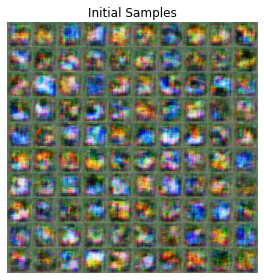

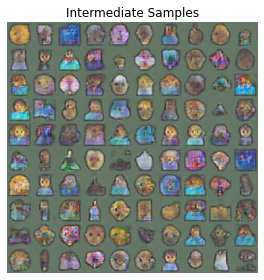

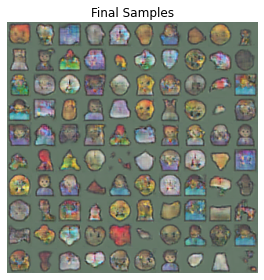

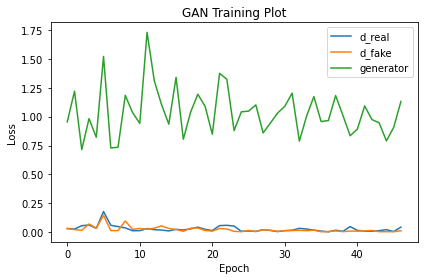

In [455]:
q1_save_results(q1)

### Once you have your results, you may execute the following cell to visualize a gif of generated samples throughout the training. You don't need to include this in the report.

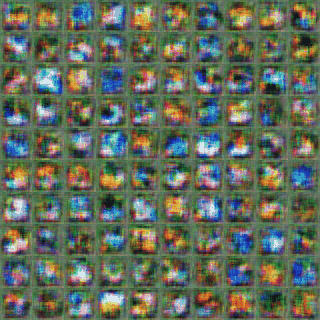

In [457]:
from IPython.display import Image as GIF
GIF(open('temp/q1/samples/anim.gif','rb').read())

 ### <font color='red'> Inline Question 1 </font>

*   Sometimes the original GAN objective is called as the *saturating loss*. Why do you think it is called this way? Is there an alternative loss function? What are the differences of this alternative and how are these differences helping? Please briefly explain.

<font color='red'> Your Answers </font>
* The problem with the original GAN objective is that the discriminator can learn to perfectly identify real from fake and vise versa, where as the generator might have not been optimized yet, hence this can cause the gradient to be very close to zero which is called the saturating loss. To avoid this, an alternative solution is to change the perspective of generator loss, meaning, think of the generator loss as maximizing the probablity of an image being identified as real. the proposed objective is to maximize the -log(D(G(z))) which prevents the loss from getting very close to zero.


# Question 2: CycleGAN [25 pts]

In this part, you will implement a CycleGAN model that will convert Windows emojis to Apple emojis and the other way around.

### Solution

This will be an image to image translation task. The task of the generator will be to take an image and translate it to another domain. 

The generator in the CycleGAN has layers that implement three stages of computation: 1) the first stage *encodes* the input via a series of convolutional layers that extract the image features; 2) the second stage then *transforms* the features by passing them through one or more *residual blocks*; and 3) the third stage *decodes* the transformed features using a series of transpose convolutional layers, to build an output image of the same size as the input. 

The residual block used in the transformation stage consists of a convolutional layer, where the input is added to the output of the convolution. This is done so that the characteristics of the output image (e.g., the shapes of objects) do not differ too much from the input. Here is a figure summarizing the CycleGAN.

![](https://drive.google.com/uc?export=view&id=1ED3F_E2uuUIFszie0wuHgmUX2wb7Wuy2)


We will start by implementing a ResnetBlock. This will be a very simple one, containing only a convolutional layer and a batch normalization layer. Here is the pseudocode:



```
ResnetBlock
    Conv2d(conv_dim, conv_dim, 3, stride=1, padding=1)
    BatchNorm2d(conv_dim)
    add the input back
```



In [458]:
class ResnetBlock(nn.Module):
    def __init__(self, conv_dim):
        super(ResnetBlock, self).__init__()
        """ YOUR CODE HERE """
        self.rb = nn.Sequential(
            nn.Conv2d(conv_dim, conv_dim, 3, stride=1, padding=1),
            nn.BatchNorm2d(conv_dim)
        )

    def forward(self, x):
        """ YOUR CODE HERE """
        out = self.rb(x)
        out += x
        return out

Now, we can implement the generator. As discussed above, the generator will consist of 3 parts. Here is a pseudocode for the generator network:


```
# Encoding
Conv2d(3, 64, 5, stride=2, padding=2, bias=False)
BatchNorm2d(64)
ReLU
Conv2d(64, 128, 5, stride=2, padding=2, bias=False)
BatchNorm2d(128)
ReLU

# Transforming
ResnetBlock(128)
ReLU

# Decoding
nn.Upsample(2)
Conv3d(128, 64, 5, stride=1, padding=2, bias=False)
BatchNorm2d(64)
ReLU
nn.Upsample(2)
Conv3d(64, 3, 5, stride=1, padding=2, bias=False)
tanh
```



In [459]:
class CycleGenerator(nn.Module):
    """Defines the architecture of the generator network.
       Note: Both generators G_XtoY and G_YtoX have the same architecture in this assignment.
    """
    def __init__(self,):
        super(CycleGenerator, self).__init__()
        """ YOUR CODE HERE """
        # 1. Define the encoder part of the generator (that extracts features from the input image)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        # 2. Define the transformation part of the generator
        self.transformation = nn.Sequential(
            ResnetBlock(128),
            nn.ReLU()
        )

        # 3. Define the decoder part of the generator (that builds up the output image from features)
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(128, 64, 5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor = 2),
            nn.Conv2d(64, 3, 5, stride=1, padding=2, bias=False),
            nn.Tanh(),
        )
        
    def forward(self,x):
        """ YOUR CODE HERE """
        out = self.encoder(x)
        out = self.transformation(out)
        out = self.decoder(out)
        return out


For the discriminators, you will use your implementation from the first question. We will use the same Generator model for `G_XtoY` and `G_YtoX` and the same Discriminator model for `D_X` and `D_Y`.

We are ready to write the training loop. Again, the following cell already contains a function template for you. You will need to complete the necessary parts. Please fill in the parts saying `YOUR CODE HERE` according to the comments above them. Don't forget to return your loss lists in the end.

Use a single optimizer for the two generators and a single optimizer for the two discriminators. Use Adam optimizer, `learning rate = 0.0003` and `beta1 = 0.3` and `beta2 = 0.999` for both optimizers.

Here is a summary of the training procedure:

![](https://drive.google.com/uc?export=view&id=1XB0hM6vyM9QkjDHQVzjhDeVu0S-tLrlm)



In [465]:
import itertools
def cyclegan_training_loop(G_XtoY, G_YtoX, D_X, D_Y, dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y):
    # Create optimizers as discussed above
    """ YOUR CODE HERE """

    # Data iterators are created
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # We will again keep some fixed inputs to visualize throughout training
    fixed_X = (test_iter_X.next()[0]).cuda()
    fixed_Y = (test_iter_Y.next()[0]).cuda()

    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)
    iteration = 1
    iter_per_epoch = min(len(iter_X), len(iter_Y))
    epochs = 50 

    # Initialize empty lists to hold d_fake, d_real and the generator losses
    d_fake = []
    d_real = []
    g_loss = []
    
    lr = 3e-4
    beta1 = 3e-1
    beta2 = 999e-3
    
    optimizer_G = optim.Adam(itertools.chain(G_XtoY.parameters(), G_YtoX.parameters()), lr=lr, betas=(beta1, beta2))
    optimizer_D = optim.Adam(itertools.chain(D_X.parameters(), D_Y.parameters()), lr=lr, betas=(beta1, beta2))
    """ YOUR CODE HERE """
    for epoch in range(epochs):
        iter_X = iter(dataloader_X)
        iter_Y = iter(dataloader_Y)
        for itr in range(iter_per_epoch):
            images_X, _ = iter_X.next()
            images_X = images_X.cuda()
            
            images_Y, _ = iter_Y.next()
            images_Y = images_Y.cuda()

            # ============================================
            #            TRAIN THE DISCRIMINATORS
            # ============================================
            
            # Here, you need to update the discriminators, here is a pseudocode
              # Step 1: real
              # call zero grad
            optimizer_D.zero_grad()
            #D_Y.zero_grad() #NO NEED I GUESS
              # pass the real X images through D_X
            real_x = D_X(images_X)
              # calculate the D_X real loss
            ones = torch.ones_like(real_x, requires_grad = False, device = device)
            real_loss_x = F.mse_loss(real_x, ones)
              # pass the real Y images through D_Y
            real_y = D_Y(images_Y)
              # calculate the D_Y real loss
            ones_real = torch.ones_like(real_y, requires_grad = False, device = device)
            real_loss_y = F.mse_loss(real_y, ones_real)
              # total real loss is sum of the two
            real_loss = real_loss_x + real_loss_y
              # backward
            real_loss.backward()
              # take optimizer step
            optimizer_D.step()

              # Step 2: fake
              # call zero grad
            #D_X.zero_grad() #NO NEED I GUESS
            optimizer_D.zero_grad()
              # pass the real images Y through G_YtoX to get fake X images
            fake_x = G_YtoX(images_Y)
              # pass the fake X images through D_X
            fake_d_x = D_X(fake_x)
              # calculate D_X fake loss
            zeros = torch.zeros_like(fake_d_x, requires_grad = False, device = device)
            fake_loss_x = F.mse_loss(fake_d_x, zeros)
              # pass the real images X through G_XtoY to get fake Y images
            fake_y = G_XtoY(images_X)
              # pass the fake Y images through D_Y
            fake_d_y = D_Y(fake_y)
              # calculate D_Y fake loss
            zeros_fake = torch.zeros_like(fake_d_y, requires_grad = False, device = device)
            fake_loss_y = F.mse_loss(fake_d_y, zeros_fake)
              # total fake loss is sum of the two
            fake_loss = fake_loss_x + fake_loss_y
              # backward
            fake_loss.backward()
              # take optimizer step
            optimizer_D.step()
            """ YOUR CODE HERE """

            
            # =========================================
            #            TRAIN THE GENERATORS
            # =========================================

            # Here, you need to update the discriminators, here is a pseudocode
              # Step 1: Y -> X -> Y
              # call zero grad
            optimizer_G.zero_grad()
              # pass the real images Y through G_YtoX to get fake X images
            fake_x = G_YtoX(images_Y)
              # pass the fake X images through D_X
            fake_x_d = D_X(fake_x)
              # calculate g_loss
            ones_g = torch.ones_like(fake_x_d, requires_grad = False, device = device)
            g_loss_G = F.mse_loss(fake_x_d, ones_g)
              # pass the fake X images through G_XtoY to reconstruct Y images
            recon_y = G_XtoY(fake_x)
              # calculate consistency loss between real Y images and reconstructed ones (mean absolute error)
            abs_diff = torch.abs((images_Y - recon_y))
            loss_sum = torch.sum(abs_diff, dim = (1, 2, 3))
            consistency_loss = torch.mean(loss_sum, dim = 0)
              # with 0.015 multiplier, add the cycle consistency loss to g_real 
            g_loss_total = g_loss_G + (consistency_loss * 0.015)
              # backward g_loss
            g_loss_total.backward() #BACKWARD ON THIS?
              # take optimizer step
            optimizer_G.step()
              # Step 2: X -> Y -> X
              # call zero grad
            optimizer_G.zero_grad()
              # pass the real images X through G_XtoY to get fake Y images
            fake_y_img = G_XtoY(images_X)
              # pass the fake Y images through D_Y
            fake_y_d_img = D_Y(fake_y_img)
              # calculate g_loss
            ones_gtx = torch.ones_like(fake_y_d_img, requires_grad = False, device = device)
            g_loss_mse = F.mse_loss(fake_y_d_img, ones_gtx)
              # pass the fake Y images through G_YtoX to reconstruct X images
            recon_x = G_YtoX(fake_y_img)
              # calculate consistency loss between real Y images and reconstructed ones (mean absolute error)
            abs_diff = torch.abs((images_X - recon_x)) #DID THEY MEAN X?
            loss_sum = torch.sum(abs_diff, dim = (1, 2, 3))
            consistency_loss2 = torch.mean(loss_sum, dim = 0)
              # with 0.015 multiplier, add the cycle consistency loss to g_real 
            g_loss_total_x = g_loss_mse + (consistency_loss2 * 0.015)
              # backward g_loss
            g_loss_total_x.backward()
              # take optimizer step
            optimizer_G.step()
             # """ YOUR CODE HERE """

            if iteration % 200 == 0:
                # Append losses to you lists (d_real, d_fake, g_loss)
                d_real.append(real_loss.detach().cpu().item())
                d_fake.append(fake_loss.detach().cpu().item())
                g_loss.append((g_loss_total + g_loss_total_x).detach().cpu().item())
                # You may also wish to print them here for logging purposes
                #""" YOUR CODE HERE """
                print(
                    "[Epoch %d/%d] [Iteration %d] [d_real loss: %f] [d_fake loss: %f] [Generator loss: %f]"
                    % (epoch, epochs, iteration, real_loss.item(),fake_loss.item(), (g_loss_total + g_loss_total_x).item())
                )
            iteration += 1

        # We are getting samples from the fixed inputs, every 10 epochs 
        if epoch % 10 == 0 or epoch+1 == epochs:
            cyclegan_save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY)
            
    # Return the loss lists
    #""" YOUR CODE HERE """
    return d_real, d_fake, g_loss

Now, we will define a simple function, that creates the dataloaders as well as the models and trains the models using the function you filled above. Please complete the following function, the instructions are given as comments.

In [466]:
def q2():
    x_train_loader, x_test_loader = get_emoji_dataloader('Windows')
    y_train_loader, y_test_loader = get_emoji_dataloader('Apple')
    # initialize G_XtoY, G_YtoX, D_X and D_Y
    G_XtoY = CycleGenerator().to(device)
    G_YtoX = CycleGenerator().to(device)
    
    D_X = DCDiscriminator().to(device)
    D_Y = DCDiscriminator().to(device)
    # Pass the models and the dataloaders to the cyclegan_training_loop function that returns the losses
    d_real_loss, d_fake_loss, g_loss = cyclegan_training_loop(G_XtoY, G_YtoX, D_X, D_Y,
                                                              x_train_loader, y_train_loader,
                                                              x_test_loader, y_test_loader) #CORRECT?
                                                              
    return d_real_loss, d_fake_loss, g_loss

### Results

Once you've finished `q2`, execute the cell below to visualize and save your results. **You need to include the initial, intermediate and final results in your latext report as well as the training plots.** Also, include your final losses in the latex template.

Saved temp/q2/samples/sample-000000-X-Y.png
Saved temp/q2/samples/sample-000000-Y-X.png
[Epoch 3/50] [Iteration 200] [d_real loss: 0.226089] [d_fake loss: 0.154382] [Generator loss: 17.492191]
[Epoch 6/50] [Iteration 400] [d_real loss: 0.301154] [d_fake loss: 0.264333] [Generator loss: 13.953075]
[Epoch 9/50] [Iteration 600] [d_real loss: 0.311341] [d_fake loss: 0.145823] [Generator loss: 12.786111]
Saved temp/q2/samples/sample-000010-X-Y.png
Saved temp/q2/samples/sample-000010-Y-X.png
[Epoch 12/50] [Iteration 800] [d_real loss: 0.193429] [d_fake loss: 0.091400] [Generator loss: 13.148043]
[Epoch 15/50] [Iteration 1000] [d_real loss: 0.311328] [d_fake loss: 0.248622] [Generator loss: 11.976656]
[Epoch 19/50] [Iteration 1200] [d_real loss: 0.081749] [d_fake loss: 0.059396] [Generator loss: 11.782030]
Saved temp/q2/samples/sample-000020-X-Y.png
Saved temp/q2/samples/sample-000020-Y-X.png
[Epoch 22/50] [Iteration 1400] [d_real loss: 0.191798] [d_fake loss: 0.070771] [Generator loss: 11.69

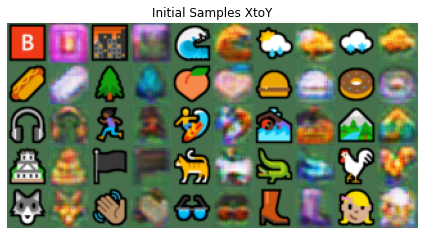

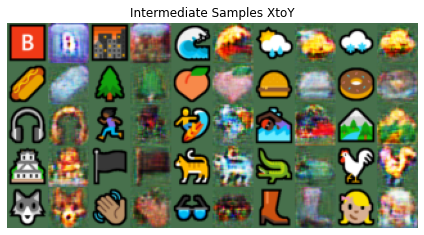

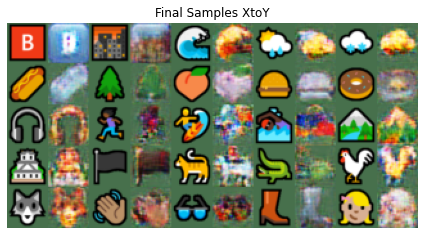

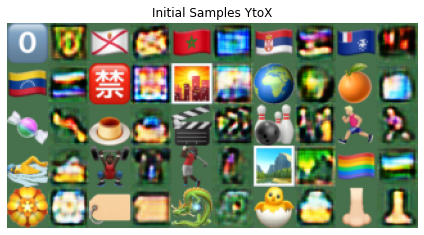

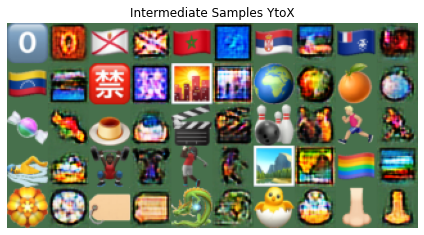

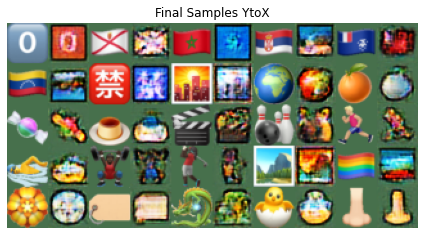

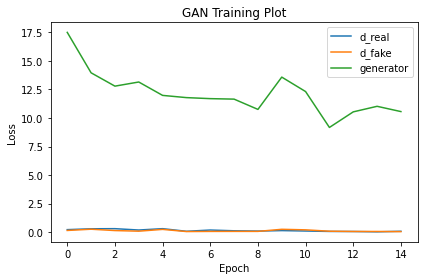

In [467]:
q2_save_results(q2)

Once you have your results, you may execute the following cells to visualize gifs of original emojis and reconstructed versions from your model. You don't need to include these in the report.

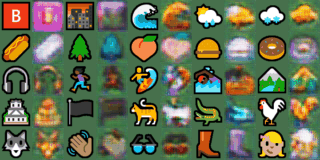

In [468]:
GIF(open('temp/q2/samples/anim_X-Y.gif','rb').read())

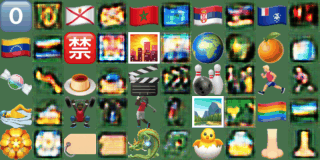

In [469]:
GIF(open('temp/q2/samples/anim_Y-X.gif','rb').read())

 ### <font color='red'> Inline Question 2 </font>

*   Mode Collapse is a common issue with training GANs. Please briefly explain what mode collapse is, when it happens and what are some possible ways to avoid it.

<font color='red'> Your Answers </font>
* Mode Collapse happens when the generator learns to generate a single type of output or a small subset of outputs, hence lacking variety. This happens when the generator finds a set of outputs that is most plausible for the discriminator. A proposed solution is in AdaGAN where multiple GANs are trained and combined, each covering different modes that model produces. Another solution is to feed real images and generated images into the discriminator separately in different batches and computing the similarity of differnet images in the same batch.


# Question 3: Diffusion-based Deep Generative Models (DDGM)

In this question, we will implement different variants of DDGM. 
As we have learnt in the lecture, DDGM works by gradually applying a diffusion process on the input(e.g adding a Gaussian diffusion) for T different steps and learns the reverse of this diffusion at each step t $\in$ {1, 2, .. , T} as a function $F_{t_{\theta}}$ parameterized by a neural network. We will implement this model in two different ways!

## Part (A): Diffusion Probabilistic Models (DPM) on Low-Res MNIST Dataset [25 pts]
In this part, we will use a diffusion probabilistic model to generate samples of low-resolution MNIST digits dataset.

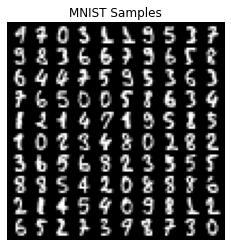

In [1145]:
visualize_low_res_mnist()

**DPM forward and reverse diffusion process is defined as:**
```
diffusion(x)
  foreach beta in variance_scheduler:
    x = sqrt(1-beta) x + sqrt(beta) * noise(0, beta)

reverse_diffusion(z)
  foreach network in denoising_networks:
    mean, log_var = network(z)
    z = sample_normal(mean, exp(log_var))
  x = out_network(z)
```

**Construct the DPM with the following specifications** 
- Model every diffusion step t with a separate function $f_{t_\theta}$ parameterized with a multi-layer perceptron with three hidden layers. 
    - Hint: For each dimension of your input, you should predict two numbers (mean and log variance). That is, the output of your denoising function $f_{t_\theta}$ should be 2 * D, where D is the number of dimensions of your input
- Use a fixed variance schedule $\beta$ that starts with value $\beta_1$ and linearly increases towards $\beta_2$ throughout the T diffusion steps. We assume that the covariance matrix is the identiy matrix $I$
    - Hint: You can use reparameterization trick to add noise to your input: $x_{t+1} = \sqrt{1-\beta_{t}} * x_{t} + \sqrt{\beta_{t}} * z_t;$ where $(z_t \sim N(0, 1))$ although $\beta$ is not learnable
- Use an additional MLP layer (out_netowkr) after the last denoising layer before returning the results
- The objective of DPM is maximizing the ELBO. You can think of the diffusion steps as multiple intermediate VAEs. Therefore the ELBO objective is defined as: <br>
    $L_{ELBO} = L_{T} + L_{T-1} + L_{T-2} + \dots + L_{0}$ <br>
    Where: <br>
    $L_{T} = KL(q_{T_\phi}(X_{T}|X_{0}) || p_{T_\theta}(X_T))$ <br>
    $L_{t} = KL(q_{t_\phi}(X_{t}|X_{t+1} )|| p_{t_\theta}(X_t | X_{t-1}))$ for 1 <= t < T <br>
    $L_0 = -\log p_{\theta}(X_0 | X_1)$ <br>
    Where p represents the distribution of the forward diffusion process, and q represents the distribution of the reverse diffusion process. <br>
    **Notice the followings in the objective:**
    - p and q can be both gaussian distributions. The parameters of $p_{t_\theta}$ are fixed $(\sqrt{1-\beta_{t}} X_{t}, \beta)$ and the parameters of q are learnd. The KL divergence can be estimated as $KL(q||p) = \frac{1}{N} \sum_{i=1}^{N} log(p(x_i)) - log(q(x_i))$
    - $L_T$ is a constant term and therefore can be dropped for the optimization purposes
    - $L_0$ is the same as the reconstuction loss: $- \log p(\text{out_network}(X_1) - X_0)$ where p is a normal standard distribution
    





**The following hyperparameters are suggested for obtaining minimum results:**
- Number of denoising steps (T) : 10
- Variance schedule : (0.2 -> 0.6).
- Hidden dimensions: 256
- LR: 1e-3
- Epochs: 50


**You will provide the following deliverables**
1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained DPM

For more details, please refer to (Sohl-Dickstein et al) Deep unsupervised learning using nonequilibrium thermodynamics
    

In [441]:
# the following helper functions are given to you
PI = torch.from_numpy(np.asarray(np.pi))

def log_normal_diag(x, mu, log_var):
    """
    calculate p(x) of a normal disturbution with parameters (mu, exp(log_var))
    """
    log_p = -0.5 * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.
    return log_p
    
def log_standard_normal(x):
    """
    calculate p(x) of a normal disturbution with parameters (mu, exp(log_var))
    """
    log_p = -0.5 * torch.log(2. * PI) - 0.5 * x**2.
    return log_p

In [442]:
def diffusion(x, betas):
    x.to(device)
    ps = [] #keeps p(x) from 0 to T
    betas.to(device)
    noise = torch.randn_like(x)
    #noise2 = np.random.normal(0.0, 1.0, size = None)
    x_1 = torch.sqrt(1 - betas[0]) * x + torch.sqrt(betas[0]) * noise
    
    for beta in betas:
        x_forward = torch.sqrt(1 - beta) * x + torch.sqrt(beta) * noise
        ps.append(log_normal_diag(x_forward, torch.sqrt(1 - beta) * x, torch.log(beta)))
        x = x_forward
        
    return x, x_1, ps


def reverse_diffusion(z, denoising_networks, out_network):
    z.to(device)
    qs = []
    means = [] #keeps z from 0 to T
    log_vars = []
    for network in denoising_networks:
        network.to(device)
        mean, log_var = network(z)
        #print(z.shape)
        #log_var = log_var.float()
        #mean = mean.float()
        #mean = torch.tensor(mean)
        #log_var = torch.tensor(log_var)
        
        z = torch.normal(mean = mean, std = torch.exp(log_var))
        q = log_normal_diag(z, mean, log_var).to(device)
        #means.append(mean)
        #log_vars.append(log_vars)
        
        qs.append(q)
        
    out_network.to(device)
    x = (out_network(z))
    
    return x, qs

In [443]:
class MLP(nn.Module):
    def __init__(self, D, H):
        super().__init__()
        self.D = D
        self.H = H
        
        self.layers = nn.Sequential(nn.Linear(D,H),
                                    nn.ReLU(),
                                    nn.Linear(H,H),
                                    nn.ReLU(),
                                    nn.Linear(H,H),
                                    nn.ReLU(),
                                    nn.Linear(H,H),
                                    nn.ReLU(),
                                    nn.Linear(H, 2 * D))
        
    def forward(self, x):
        x.to(device)
        mu, log_var = self.layers(x).chunk(2, dim = 1)
        return mu, log_var
    
class Out_network(nn.Module):
    def __init__(self, D, H):
        super().__init__()
        self.D = D
        self.H = H
        
        self.layers = nn.Sequential(nn.Linear(D, H),
                                nn.ReLU(),
                                nn.Linear(H, H),
                                nn.ReLU(),
                                nn.Linear(H, H),
                                nn.ReLU(),
                                nn.Linear(H, H),
                                nn.ReLU(),
                                nn.Linear(H, D),
                                nn.Tanh())
    
    def forward(self, x):
        x = self.layers(x)
        return x
                                    

In [444]:
class DPM(nn.Module):
    def __init__(self, denoising_networks, out_network, D, steps, betas):
        super().__init__()
        """ YOUR CODE HERE """ 
        self.denoising_networks = denoising_networks
        self.out_network = out_network
        self.D = D
        self.steps = steps
        self.betas = betas
        
        #add parameters of the model
    """ YOUR CODE HERE """ 
    def loss(self, x):
        
        #diffusion and reverse_diffusion steps
        x_T, x_1, ps = diffusion(x, self.betas)
        x_0, qs= reverse_diffusion(x_T, self.denoising_networks, self.out_network)
        
        #L0 = -logp(X_0 | X_1)
        L_0 = -log_standard_normal((self.out_network(x_1) - x)).mean() #is this x or x_0
        
        #L_T : need the mean and variance of x_0
        #TODO fix l_elbo
        
        L_t = 0
        qs.reverse()
        #means.reverse()
        #log_vars.reverse()
        for step in range(self.steps):
            L_t += (ps[step] - qs[step]).mean()
        
        L_elbo = (L_0 + L_t)
        return OrderedDict(loss= L_elbo, recon_loss= L_0,
                           kl_loss=L_t)
    
    def sample(self, N):
        #sampling is giving a noise vector and reversing the diffusion process to obtain the real image

        with torch.no_grad():
            z = torch.randn([N, 64]).to(device)
            sample, qs = reverse_diffusion(z, self.denoising_networks, self.out_network)
            sample = (sample + 1) * 255/2

        return torch.reshape(sample, (N, 8, 8, 1)).cpu().numpy()
    

In [448]:
from collections import OrderedDict
from tqdm import tqdm
def train(model, train_loader, optimizer, epoch, quiet):
    model.train()

    if not quiet:
        pbar = tqdm(total=len(train_loader.dataset))
    losses = OrderedDict()
    for x in train_loader:
        x = x.cuda()
        out = model.loss(x)
        optimizer.zero_grad()
        out['loss'].backward()
        optimizer.step()

        desc = f'Epoch {epoch}'
        for k, v in out.items():
            if k not in losses:
                losses[k] = []
            losses[k].append(v.item())
            avg_loss = np.mean(losses[k][-50:])
            desc += f', {k} {avg_loss:.4f}'

        if not quiet:
            pbar.set_description(desc)
            pbar.update(x.shape[0])
    if not quiet:
        pbar.close()
    return losses


def eval_loss(model, data_loader, quiet):
    model.eval()
    total_losses = OrderedDict()
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda()
            out = model.loss(x)
            for k, v in out.items():
                total_losses[k] = total_losses.get(k, 0) + v.item() * x.shape[0]

        desc = 'Test '
        for k in total_losses.keys():
            total_losses[k] /= len(data_loader.dataset)
            #desc += f', {k} {total_losses[k]:.4f}'
        if not quiet:
            print(desc)
    return total_losses


def train_epochs(model, train_loader, test_loader, train_args, quiet=True):
    epochs, lr = train_args['Epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses, test_losses = OrderedDict(), OrderedDict()
    
    for epoch in range(epochs):
        model.train()
        train_loss = train(model, train_loader, optimizer, epoch, quiet)
        test_loss = eval_loss(model, test_loader, quiet)

        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
                test_losses[k] = []
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
        
    return train_losses, test_losses

In [449]:
def q3_a(train_data, test_data, part):
    """
    train_data: An (n_train, 64) numpy array of floats of 8x8 MNIST digits being flattend and normalized between 0-1
    test_data: An (n_test, 64) numpy array of floats of 8x8 MNIST digits being flattend and normalized between 0-1

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and sum of the KL terms evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 8, 8, 1) numpy array of 10 samples from your DDGM with values in {0, ..., 255}
    """

    train_loader = DataLoader(2 * train_data - 1, batch_size=128, shuffle=True)
    test_loader = DataLoader(2 * test_data -1 , batch_size=128)

    """ YOUR CODE HERE """ 
    D = 64
    H = 256
    T = 10
    lr = 0.001
    Epochs = 50
    betas = torch.linspace(0.2, 0.6, T)
    denoising_networks = [MLP(D, H) for i in range(T)]
    
    out_network = Out_network(D, H).to(device)
    
    model = DPM(denoising_networks, out_network, D, T, betas).to(device)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader, {'lr' : lr, 'Epochs' : Epochs})
    samples = model.sample(100)
    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis = 1)

    return train_losses, test_losses, samples

Final -ELBO: 5.8249, Recon Loss: 0.9520, KL Loss: 4.8729


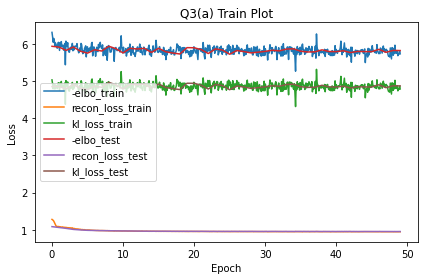

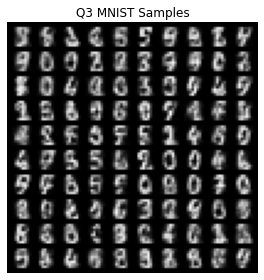

In [450]:
q3_save_results('a', q3_a)

### <font color='red'> Inline Question 3 </font>

*   How does noise parameter $\beta$ and number of diffusion steps (T) affect the diffusion process? 
*   When decreasing the number of steps (T), should we increase or decrease the value of $\beta$ and why? 
*  Lastly, what is the drawback of increasing the number of diffusion steps (T).

<font color='red'> Your Answers </font>

* Beta determines how much noise we add and diffuse the image each step. T is how many times we diffuse it. When T is increased, the noisiness of the image also increases.
* The values of beta should be increased since in the original paper the suggested equation for fixed betas has inverse relationship between beta and T to balanced the noise. Moreover, since T has been, increased, we probably need to add less noise to the image so that reverse diffusion is successful in less steps.
* One drawback is that it takes longer to train and sample when T is set to larger values.

## Part B) Diffusion Denosing Generative Models [25 pts]
implementing DDGM on Fashion MNIST dataset

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting deepul/homeworks/hw3/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to deepul/homeworks/hw3/data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting deepul/homeworks/hw3/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to deepul/homeworks/hw3/data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting deepul/homeworks/hw3/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to deepul/homeworks/hw3/data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting deepul/homeworks/hw3/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to deepul/homeworks/hw3/data/FashionMNIST/raw

Processing...
Done!


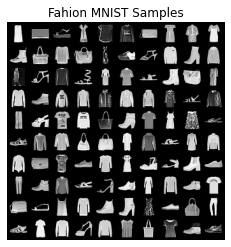

In [1127]:
visualize_fashion_mnist()

**Observe the following shortcomings in the implementation of Part A**:
- **Having separate networks for each reverse diffusion step**:
    this results in high and inefficient memory usage. Alternatively, we can use a single neural network for all of the reverse diffusion steps that is conditioned on the denoising step t. In order to condition the neural network on t, we add the position encoding of t to the input of the neural network $x_t$.
    
- **Traversing all of the diffusion steps on every training iteration**: this would require backpropagating through all of the diffusion steps at each training step which would limit the maximum number of steps that we can use.
Considering the diffusion process mentioned in part (A) and assuming that $\alpha_t = 1 - \beta_t$ we can derive that:<br>
$x_{t+1} = \sqrt{\alpha_{t}} * x_{t} + \sqrt{1 - \alpha_{t}} * z_t;$ where $(z_t \sim N(0, 1))$ <br>
$x_{t+1} = \sqrt{\alpha_{t} \alpha_{t-1}} * x_{t-1} + \sqrt{1 - \alpha_{t} \alpha_{t-1}} * \bar{z}_{t-2}$; where ($\bar{z}_{t-2}$ merges two gaussians) <br>
$x_{t+1} = \sqrt{\bar{\alpha}_{t}} * x_{0} + \sqrt{1 - \bar{\alpha}_{t}} * z;$ where $(z \sim N(0, 1))$ and $\bar{\alpha}_{t} = \Pi_{i=1}^{t} \alpha_{i}$

    This reparameterization is very useful for efficient optimization. As calculating $X_t$ no longer requires calculated the intermediate latents $X_{t-1}, X_{t-2} ...$, we can now sample step $t \sim {\{1, 2, \dots T\}}$ at each training step, calculate $X_t$ and optimize accordingly without having to do the forward and backwared diffusion process for all steps T. 

In this part, we aim to overcome these two shortcomings by implementing the suggested solutions above
   
**Construct the DPM with the following specifications**
- Fixed variance schedule that increases linearly $\beta (1e-4, 0.02)$
- Model the reverse diffusion step with a UNet architecture conditioned on the reverse diffusion step t. 
- Add positional encoding of the diffusion step $t$ to every layer in the Unet by repeating the position embeddings of size $C$ for $D\times D$ times and adding it to the output of that layer $Z_t$ Where $C \times D\times D$ is the output dimension of that layer ($Z_t$)
- The objective for DDGM is quit simpler than part(A) and defined as: <br>
    $L_t = \mathbb{E}_{\mathbf{x}_0, \mathbf{z}_t} \Big[\|\mathbf{z}_t - \mathbf{z}_\theta(\sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\mathbf{z}_t, t)\|^2 \Big]$ <br>
    where $z_t$ is the sampled noise from the normal distribution and $z_\theta$ is a neural network that predicts the sampled noise. That means that the objective is defined as the L2 loss between the sampled noise and the predicted noise (to be removed) by the neural netowork $z_\theta$. For more details about the objective and its derivations, please refer to (Ho et al.) Denoising Diffusion Probabilistic Models.
   
- Use the following training and sampling algorithms: 
![Image](https://i.ibb.co/cxSpCsS/DDPM-algo.png)


**Positional Encoding:**

Use the Transformer positional encoding in your DDGM [(Reference)](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)

You might find the following pseudocode helpful:
```
pos_encoding(t):
  w = 1 / 1000 ^ (range(0, C, 2) / C)
  p[:, 0::2] = sin(t.repeat(1, C)[:, 0::2])
  p[:, 1::2] = cos(t.repeat(1, C)[:, 1::2])
  return p.repeat(1, 1, D, D)
```

**The following Unet architecture is suggested for modeling the reverse diffusion process:** <br>
```
    // downsampling 
    x <- relu(conv2d(1, 64, 3)(x)) # 32 x 32
    x1 <- relu(downsample(x)) # 16 x 16
    x1 <- relu(ResnetBlock(64, 64)(x1)) 
    x1 <- relu(conv2d(64, 128)(x1)) + pos_encoding(t)

    x2 <- relu(downsample(x1)) # 8 x 8  
    x2 <- relu(ResnetBlock(128, 128)(x2)) 
    x2 <- relu(conv2d(128, 256)(x2)) + pos_encoding(t)

    x3 <- relu(downsample(x2)) # 4 x 4
    x3 <- relu(ResnetBlock(256, 256)(x3))
    x3 <- relu(conv2d(256, 512)(x3)) + pos_encoding(t)
    
    // upsampling 
    x4 <- relu(upsample(x3)) # 8 x 8
    x4 <- relu(conv2d(512, 256)(x4)) + pos_encoding(t)
    x4 <- cat(x4, x2) + pos_encoding 

    x5 <- relu(upsample(x4)) # 16 x 16 
    x5 <- relu(conv2d(256, 128)(x5)) + pos_encoding(t)
    x5 <- cat(x5, x1) + pos_encoding <br>
    
    x6 <- relu(upsample(x5)) # 32 x 32 
    x6 <- relu(conv2d(128, 64)(x6)) + pos_encoding(t)
    x6 <- cat(x6, x) + pos_encoding 
    
    out <- conv2d(64, 1, 1)(x6) # 1x1 conv 
```

**The following hyperparameters are suggested for obtaining minimum results:**
- Number of denoising steps (T) : 1000
- Variance schedule : (1e-4 -> 0.01)
- LR: 0.0001
- Epochs: 10


**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 10 samples from your trained DDGM along with 5 intermediate latents for each image taken from steps {0, 200, 400, .., 1000}

In [482]:
import torch
import torch.nn as nn
import math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class ResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels))
        
    def forward(self, x):
        out = self.block(x)
        out += x
        out = F.relu(out)
        return out
        
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        """ YOUR CODE HERE """ 
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.init_conv_layer = nn.Conv2d(1, 64, 3, 1, 1)
        self.conv2d_64 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv2d_128 = nn.Conv2d(128, 256, 3, 1, 1)
        self.conv2d_256 = nn.Conv2d(256, 512, 3, 1, 1)
        self.resnet_64 = ResnetBlock(64, 64)
        self.resnet_128 = ResnetBlock(128, 128)
        self.resnet_256 = ResnetBlock(256, 256)
        self.downsample = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        

            
        
        #loop(downsample -> resnet -> conv2d + emb)
    def forward(self, x, t):
        x = x.to(device)
        x = F.relu(self.init_conv_layer(x))
        x_1 = F.relu(self.downsample(x))
        x_1 = F.relu(self.resnet_64(x_1))
        x_1 = F.relu(self.conv2d_64(x_1))
        x_1 += PosEncoding(x_1.shape[0], 128, 16)(t) # b * 128 * 16 * 16
        
        #t = 2
        x_2 = F.relu(self.downsample(x_1)) # b * 128 * 8 * 8
        x_2 = F.relu(self.resnet_128(x_2))
        x_2 = F.relu(self.conv2d_128(x_2)) # b * 256 * 8 * 8
        x_2 += PosEncoding(x_2.shape[0], 256, 8)(t)
        
        #t = 3
        x_3 = F.relu(self.downsample(x_2)) #b * 256 * 4 * 4
        x_3 = F.relu(self.resnet_256(x_3)) 
        x_3 = F.relu(self.conv2d_256(x_3)) #b * 512 * 4 * 4
        x_3 += PosEncoding(x_3.shape[0], 512, 4)(t)
        
        return [x_1, x_2, x_3, x]


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        """ YOUR CODE HERE """
        self.in_channels = in_channels
        self.out_channels = out_channels
        #self.upsample = nn.Upsample(scale_factor = 2) #change to convtranspose2d
        self.conv2d_512 = nn.Conv2d(512, 256, 3, 1, 1)
        self.conv2d_256 = nn.Conv2d(256, 128, 3, 1, 1)
        self.conv2d_128 = nn.Conv2d(128, 64, 3, 1, 1)
        self.last_conv = nn.Conv2d(64, 1, 1)
        
        #upsamplings
        self.upsample_512 = nn.ConvTranspose2d(512, 512, 4, stride=2, padding = 1) 
        self.upsample_256 = nn.ConvTranspose2d(256, 256, 4, stride=2, padding = 1) 
        self.upsample_128 = nn.ConvTranspose2d(128, 128, 4, stride=2, padding = 1) 
        
        ##after concatenation convs
        self.conv2d_cat4 = nn.Conv2d(512, 256, 3, 1, 1)
        self.conv2d_cat5 = nn.Conv2d(256, 128, 3, 1, 1)
        self.conv2d_cat6 = nn.Conv2d(128, 64, 3, 1, 1)

        
    def forward(self, X, t):
        x_1, x_2, x_3, x = X
        
        x_4 = F.relu(self.upsample_512(x_3)) # b * 512 * 8 * 8
        x_4 = F.relu(self.conv2d_512(x_4)) + PosEncoding(x_4.shape[0], 256, 8)(t) #b * 256 * 8 * 8 
        x_4 = torch.cat((x_4, x_2), dim = 1) + PosEncoding(x_4.shape[0], 512,8)(t)  #b * 256 * 8 * 8 + b * 256 * 8 * 8 = b * 512 * 8 * 8 #correct
        x_4 = F.relu(self.conv2d_cat4(x_4)) #b * 256 * 8 * 8
        
        #t = 5
        x_5 = F.relu(self.upsample_256(x_4)) # b * 256 * 16 * 16
        x_5 = F.relu(self.conv2d_256(x_5)) + PosEncoding(x_5.shape[0], 128, 16)(t) #b * 128 * 16 * 16
        x_5 = torch.cat((x_5, x_1), dim = 1) + PosEncoding(x_5.shape[0], 256, 16)(t) #b * 128 * 16 * 16 + #b * 128 * 16 * 16 = #b * 256 * 16 * 16
        x_5 = F.relu(self.conv2d_cat5(x_5)) #b * 128 * 16 * 16
        
        #t = 6
        x_6 = F.relu(self.upsample_128(x_5)) #b * 128 * 32 * 32
        x_6 = F.relu(self.conv2d_128(x_6)) + PosEncoding(x_6.shape[0], 64, 32)(t) #b * 64 * 32 * 32 
        x_6 = torch.cat((x_6, x), dim = 1) + PosEncoding(x_6.shape[0], 128, 32)(t) #b * 64 * 32 * 32 + #b * 64 * 32 * 32 = #b * 128 * 32 * 32 
        x_6 = F.relu(self.conv2d_cat6(x_6)) #b * 64 * 32 * 32 
        
        #output
        out = self.last_conv(x_6) #b * 1 * 32 * 32
        return out



class UNet(nn.Module):
    #for reverse diffusion step
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.downsample = DownSample(in_channels, out_channels)
        self.upsample = UpSample(in_channels, out_channels)
        
    def forward(self, x, t):
        X = self.downsample(x, t) #list of x's: x_1, x_2, x_3, x
        out = self.upsample(X, t)
        return out


class PosEncoding(nn.Module):
    def __init__(self, batch_size, channels, embed_size):
        super().__init__()
        """ YOUR CODE HERE """ 
        self.channel = channels #C
        self.D = embed_size # D
        self.batch_size = batch_size
        

    def forward(self, t):
        """ YOUR CODE HERE """ 
        #t = torch.tensor(t).to(device)
        #w = torch.exp((-(math.log(1000.)/ self.channel) * torch.arange(0, self.channel, 2))).to(device)
        #p = torch.zeros(1, self.channel).to(device)
        #p[:, 0::2] = torch.sin(w * t.repeat(1, self.channel)[:, 0::2])
        #p[:, 1::2] = torch.cos(w * t.repeat(1, self.channel)[:, 1::2])
        # (1, C)
        # (B, C, D, D)
        #print(p.shape)
        #p = p.unsqueeze(2)
        #p = p.unsqueeze(2)
        #p = p.repeat(self.batch_size, 1, self.embed_size, self.embed_size)
        
        #t = torch.randint(1, 1000, (256, 1)) # column vector needed
        t = t.to(device)
        t = t.unsqueeze(1) # batch_size * 1
        t = t.repeat(1, self.channel) # batch_size * channles
        w = torch.tensor([np.power(1/1000, 2 * (hid_j//2) / self.channel) for hid_j in range(0,self.channel)]).reshape(1, self.channel).to(device)
        w = w.repeat(self.batch_size, 1) # batch_size * channel
        omega_t = t * w #shape : [256, 128]
        p = torch.zeros(self.batch_size, self.channel) #256 * 128 = batch_size * channel
        p[:, 0::2] = torch.sin(omega_t[:, 0::2])
        p[:, 1::2] = torch.cos(omega_t[:, 1::2])
        p =p.unsqueeze(2)
        p = p.unsqueeze(3)
        p = p.repeat(1, 1, self.D, self.D)

        return p.to(device)

class DDGM(nn.Module):
    def __init__(self, in_size, steps, betas):
        super().__init__()
        """ YOUR CODE HERE """ 
        self.in_size = in_size
        self.unet = UNet(self.in_size, self.in_size)
        self.steps = steps
        self.betas = betas
        
    def extract(self, a, t, shape):
        #a => alpha or alphabar
        #shape => shape of x
        b = t.shape[0]
        out = a.gather(-1, t).float()
        return out.reshape(b, *((1, ) * (len(shape) - 1)))
    
    def loss(self, x):
        #sample t
        x = x.to(device)
        t = torch.randint(1, self.steps, (x.shape[0],)).to(device)
        noise = torch.normal(mean = torch.tensor(0.0), std = torch.tensor(1.0), size = x.shape).to(device)
        alphas = 1 - self.betas
        alphas = alphas.to(device)
        cumalphas = torch.cumprod(alphas, dim=0)#check this
        alpha_bar = self.extract(cumalphas, t, x.shape)
        diffusion_in = (torch.sqrt(alpha_bar) * x + torch.sqrt(1 - alpha_bar) * noise).to(device)
        diffusion = self.unet(diffusion_in, t)
        loss = F.mse_loss(noise ,diffusion)
        
        return loss
        
        
    def sample(self, N):
        
        with torch.no_grad():
            aray = []
        
            x_T = torch.normal(mean = torch.tensor(0.0), std = torch.tensor(1.0), size = [N, 1, 32, 32]).to(device)

            for t in reversed(range(self.steps)):
                alphas = (1 - self.betas).to(device)
                alpha = alphas[t]
                cumalphas = torch.cumprod(alphas, dim=0)#check this
                alpha_bar = cumalphas[t]
                if t ==1:
                    z = torch.zeros_like(x_T) #check shape
                else:
                    z = torch.normal(mean = torch.tensor(0.0), std = torch.tensor(1.0), size = x_T.shape).to(device)
                time = torch.tensor(t).unsqueeze(0).repeat(N)  
                x = torch.sqrt(1 / alpha) * (x_T - ((1 - alpha)/ torch.sqrt(1 - alpha_bar)) * self.unet(x_T, time)) + torch.sqrt(self.betas[t]) * z
                x_T = x
            
                if t % 200 == 0:
                    x_temp = F.sigmoid(x) * 255
                    aray.append(x_temp.detach().cpu().numpy())

            aray.append((F.sigmoid(x) * 255).detach().cpu().numpy())

            aray = np.array(aray)
            aray = aray.reshape(6, 10, 32, 32, 1)
                
            
        return aray
       

In [483]:

from tqdm import tqdm
def train(model, train_loader, optimizer):
    
    model.train()
    train_losses = []
    for x in train_loader:
        x = x.to(device).float()
        loss = model.loss(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
    return train_losses

def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.to(device).float()
            loss = model.loss(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()

def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)
    
    for epoch in tqdm(range(epochs)):
        model.train()
        epoch_train_losses = train(model, train_loader, optimizer) 
        train_losses.extend(epoch_train_losses)
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
            
    return train_losses, test_losses

In [484]:
def q3_b(train_data, test_data, part):
    """
    train_data: An (n_train, 32, 32, 1) uint8 numpy array of images with values normalized between 0-1
    test_data: An (n_test, 32, 32, 1) uint8 numpy array of images with values normalized between 0-1

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations) numpy array of the train loss evaluated every minibatch
    - a (# of epochs + 1) numpy array of the test loss evaluated once at initialization and after each epoch
    - a (10, 6, 32, 32, 1) numpy array of 10 samples from your DDGM with values in {0, ..., 255}
    """
    
    train_data = np.transpose(train_data, (0, 3, 1, 2)).astype(np.float32)
    test_data = np.transpose(test_data, (0, 3, 1, 2)).astype(np.float32)
    train_loader = DataLoader(2 * train_data - 1, batch_size=256, shuffle=True)
    test_loader = DataLoader(2 * test_data - 1 , batch_size=256)
    #for i,x in enumerate(train_loader):
        #unet(x, 3)

    """ YOUR CODE HERE """ 
    T = 1000
    lr = 0.0001
    Epochs = 10
    D = 32
    betas = torch.linspace(1e-4, 0.02, T)
    
    model = DDGM(D, T, betas).to(device)
    train_losses, test_losses = train_epochs(model, train_loader, test_loader, {'lr' : lr, 'epochs' : Epochs})
    samples = model.sample(10)
    
    return train_losses, test_losses, samples

100%|██████████| 10/10 [20:30<00:00, 123.07s/it]


Final loss: 0.0556


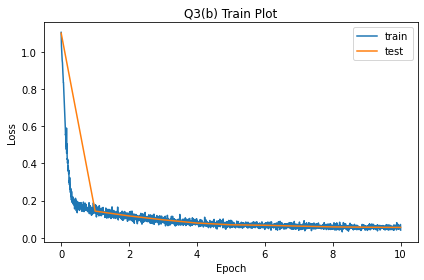

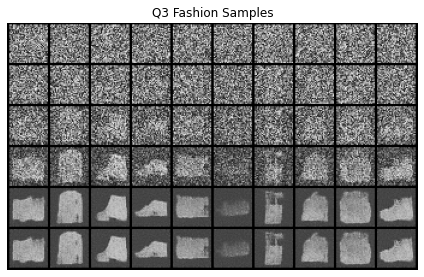

In [485]:
q3_save_results('b', q3_b)